<a href="https://colab.research.google.com/github/kap2fox/Intro-to-Robotics/blob/main/PID_control_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ПИД на Python
Эта часть посвящена моделированию работы двигателя при добавлении закона управления. На каждом шаге работы программы, как и в реальном роботе, происходит расчет управляющего напряжения. Как расчитывать управляющее напряжение - вопрос крайне обширный, который рассматривает теория автоматического управления. Базовым алгоритмом управления является **пропорционально-интегрально-дифференциальный регулятор** или ПИД-регулятор. Далее рассматривается его программная реализация.

In [ ]:
import numpy as np                            # модуль для поддержки многомерных массивов
import matplotlib.pyplot as plt               # модуль для визуализации данных
from scipy.integrate import odeint            # подключение функции численного решения дифференциальных уравнений

Для начала требуется определить параметры модели двигателя. В прошлый раз мы использовали значение времени, записанное в файл. В этот раз нам потребуется задать пространство времени самостоятельно. Для этого подойдет функция *linspace* из модуля *numpy*.

In [ ]:
T_m = 0.08                                   # электромеханическая постоянная двигателя
k_e = 0.5                                    # конструктивная постоянная 
n = 5001                                     # количество шагов моделирования
t = np.linspace(0,5,n)                       # задание пространства времени, массив n элементов значениями от 0 до 5

Далее необходимо задать модель двигателя по аналогии с предыдущей лекцией системой уравнений 5, с отличием в том, что теперь значение управляющего напряжения будет передаваться в модель на каждом шаге моделирования:
$$
\left\{
    \begin{array}\\
        \dot\omega=\frac{U}{T_m k_e}-\frac{\omega}{T_m}, \\
        \dot\theta=\omega. 
    \end{array} \tag{5}
\right.
$$

In [ ]:
def motor(state,t,u):
    speed, angle = state                                # обозначение состояния двигателя как скорости и угла поворота
    state_dt = [-speed/T_m + u/ (T_m * k_e), speed ]    # задание производной состояния двигателя
    return state_dt

Для моделирование работы ПИД-регулятора понадобится определение переменных и массивов значений регулятора. Чтобы иметь возможность посмотреть на поведение каждого из компонентов регулятора, нужно задать массивы нулей для каждого из них функцией *zeros*.

In [ ]:
Kp = 1                                                   # пропорциональный коэффициент
Ki = 0.3                                                 # интегральный коэффициент
Kd = 0.2                                                 # дифференциальный коэффициент
P= np.zeros(n)                                           # пропорциональная компонента
I = np.zeros(n)                                          # интегральная компонента
D = np.zeros(n)                                          # дифференциальная компонента
e = np.zeros(n)                                          # массив ошибок
control = np.zeros(n)                                    # управляющее воздействие
theta = np.zeros(n)                                      # массив углов поворота 
setpoint = np.zeros(n)                                   # заданный угол поворота 
setpoint[0:n] = 5                                       # задание угла поворота в 10 радиан
init = [0 , 0]                                           # начальные условия моделирования


Теперь нужно создать цикл на количество шагов моделирования и на каждой итерации вычислять значения состояния двигателя. Для этого мы воспользуемся функцией *odeint*, но моделировать будем только один шаг *(t[i-1],t[i])*. При этом каждый шаг будет начинаться с предыдущих ненулевых начальных условий *init* и учитывать текущее управляющее напряжение *control*.

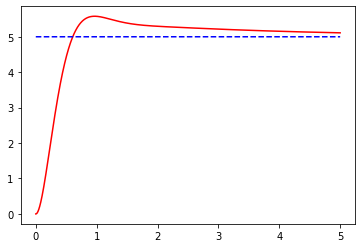

In [ ]:
for i in range(1,n):
    ts = [t[i-1],t[i]]                                   # задаем значение времени для моделирования
    state = odeint(motor,init,ts,args=(control[i-1],))   # вычисляем значения скорости и угла поворота
    #odeint возвращает две пары значений угла и скорости для моментов времени t[i-1] и t[i]
    init = state[1,:]                                    # запоминаем последние значения состояния двигателя
    theta[i] = state[1,1]                                # присваиваем текущий угол поворота
    e[i] = setpoint[i] - theta[i]                        # вычисляем ошибку между текущим и заданным значением угла поворота
    dt = t[i] - t[i-1]                                   # вычисляем значение изменения таймера, временного шага
    P[i] = Kp * e[i]                                     # вычисляем пропорциональную компоненту
    I[i] = I[i-1] + Ki * e[i] * dt                       # вычисляем интегральную компоненту методом Эйлера
    D[i] = Kd * (theta[i]-theta[i-1])/dt                 # вычисляем дифференциальную компоненту методом конечных разностей
    control[i] = P[i] + I[i] + D[i]                      # вычисляем управляющее напряжение - сумма всех компонент
    if control[i] > 8:
            control[i] = 8
    if control[i] < -8:
            control[i] = -8                              # ограничиваем значения управляющего напряжения


plt.plot(t, theta,'r-')                                  # изображаем график поведения системы
plt.plot(t, setpoint,'b--')                              # изображаем требуемый угол поворота